In [40]:
!pip install transformers

In [4]:
!pip install -q -U watermark

In [160]:
import transformers
from transformers import BertModel, Trainer, TrainingArguments, AutoTokenizer, BertTokenizer, PreTrainedTokenizerFast, AdamW, get_linear_schedule_with_warmup
import torch.nn.functional as F

import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.nn.utils import clip_grad_norm_
from torch.utils.data import Dataset, DataLoader

In [249]:
arguments = TrainingArguments(
    output_dir='data/',
    num_train_epochs=4,
)

In [3]:
!gdown --id 1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV
!gdown --id 1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv

Downloading...
From: https://drive.google.com/uc?id=1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV
To: /content/apps.csv
100% 134k/134k [00:00<00:00, 81.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv
To: /content/reviews.csv
100% 7.17M/7.17M [00:00<00:00, 242MB/s]


In [6]:
df = pd.read_csv("reviews.csv")

In [7]:
df.head()

,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,Andrew Thomas,https://lh3.googleusercontent.com/a-/AOh14GiHd...,Update: After getting a response from the deve...,1,21,4.17.0.3,2020-04-05 22:25:57,"According to our TOS, and the term you have ag...",2020-04-05 15:10:24,most_relevant,com.anydo
1,Craig Haines,https://lh3.googleusercontent.com/-hoe0kwSJgPQ...,Used it for a fair amount of time without any ...,1,11,4.17.0.3,2020-04-04 13:40:01,It sounds like you logged in with a different ...,2020-04-05 15:11:35,most_relevant,com.anydo
2,steven adkins,https://lh3.googleusercontent.com/a-/AOh14GiXw...,Your app sucks now!!!!! Used to be good but no...,1,17,4.17.0.3,2020-04-01 16:18:13,This sounds odd! We are not aware of any issue...,2020-04-02 16:05:56,most_relevant,com.anydo
3,Lars Panzerbjørn,https://lh3.googleusercontent.com/a-/AOh14Gg-h...,"It seems OK, but very basic. Recurring tasks n...",1,192,4.17.0.2,2020-03-12 08:17:34,We do offer this option as part of the Advance...,2020-03-15 06:20:13,most_relevant,com.anydo
4,Scott Prewitt,https://lh3.googleusercontent.com/-K-X1-YsVd6U...,Absolutely worthless. This app runs a prohibit...,1,42,4.17.0.2,2020-03-14 17:41:01,We're sorry you feel this way! 90% of the app ...,2020-03-15 23:45:51,most_relevant,com.anydo


In [8]:
def to_sentiment(rating):
  rating = int(rating)
  if rating <= 2:
    return 0
  elif rating == 3:
    return 1
  else: 
    return 2

df['sentiment'] = df.score.apply(to_sentiment)

In [9]:
class_names = ['negative', 'neutral', 'positive']

В качестве модели взял берт-мини, потому что (а) коллаб может снова начать ругаться, (б) соотношение скорость/качество не настолько большое.

In [11]:
PRE_TRAINED_MODEL_NAME = 'prajjwal1/bert-mini'

In [12]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/286 [00:00<?, ?B/s]

In [13]:
MAX_LEN = 256

In [161]:
class GPReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = MAX_LEN
  
  def __len__(self):
    return len(self.reviews)
  
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      padding='max_length',
      return_attention_mask=True,
      return_tensors='pt',
      truncation=True
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [162]:
RANDOM_SEED = 1
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [163]:
df_train, df_test = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [165]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df.content.to_numpy(),
    targets=df.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=1
  )

In [166]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

Изначальный классификатор.

In [258]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super().__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask,
      return_dict=False)
    output = self.drop(pooled_output)
    return self.out(output)

In [259]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

loading configuration file https://huggingface.co/prajjwal1/bert-mini/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/a32529b12a03c02e99c269bf68c0c7b8349093f626e860ab9b012e3d9539c539.e6c2a1d71adb3143ecd42222c4604e92ff255a7663c04bb5c4fad770c78e096c
Model config BertConfig {
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 256,
  "initializer_range": 0.02,
  "intermediate_size": 1024,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 4,
  "num_hidden_layers": 4,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.17.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file https://huggingface.co/prajjwal1/bert-mini/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/3baee60ec6103a88d346bbdcc74e81e9027137f2

In [266]:
EPOCHS = 3

optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [261]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    if not isinstance(outputs, torch.Tensor):
      outputs = outputs.logits

    preds = torch.argmax(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions / n_examples, np.mean(losses)

In [263]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      if not isinstance(outputs, torch.Tensor):
        outputs = outputs.logits
        
      preds = torch.argmax(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions / n_examples, np.mean(losses)

In [264]:
def train_and_eval(
    epochs,
    model,
    train_data_loader, 
    val_data_loader,
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    n_train_examples,
    n_val_examples,
    filesave='best_model_state.bin'
    ):
  
    history = defaultdict(list)
    best_accuracy = 0

    for epoch in range(epochs):

      print(f'Epoch {epoch + 1}/{epochs}')
      print('-' * 10)

      train_acc, train_loss = train_epoch(
        model,
        train_data_loader,    
        loss_fn, 
        optimizer, 
        device, 
        scheduler, 
        n_train_examples
      )

      print(f'Train loss {train_loss} accuracy {train_acc}')

      val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn, 
        device, 
        n_val_examples
      )

      print(f'Val loss {val_loss} accuracy {val_acc}')
      print()

      history['train_acc'].append(train_acc)
      history['train_loss'].append(train_loss)
      history['val_acc'].append(val_acc)
      history['val_loss'].append(val_loss)

      if val_acc > best_accuracy:
        torch.save(model.state_dict(), filesave)
        best_accuracy = val_acc
    
    return history


Результаты вполне неплохие для мини-берта.

In [267]:
first_history = train_and_eval(
    EPOCHS,
    model,
    train_data_loader, 
    val_data_loader,
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train),
    len(df_val))

Epoch 1/3
----------
Train loss 0.8047342327997324 accuracy 0.6306541562080383
Val loss 0.7124611365795136 accuracy 0.6950444579124451

Epoch 2/3
----------
Train loss 0.6937429085542063 accuracy 0.6993155479431152
Val loss 0.6763897424936295 accuracy 0.7166454792022705

Epoch 3/3
----------
Train loss 0.6548860215037455 accuracy 0.7175922989845276
Val loss 0.6719625866413117 accuracy 0.714104175567627



In [268]:
first_history['train_acc'] = [score.to('cpu') for score in  first_history['train_acc']]
first_history['val_acc'] = [score.to('cpu') for score in  first_history['val_acc']]

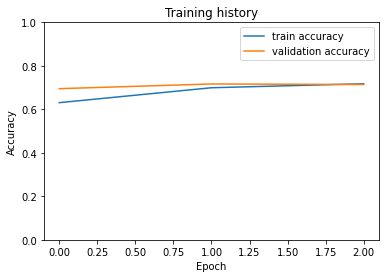

In [269]:
plt.plot(first_history['train_acc'], label='train accuracy')
plt.plot(first_history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1])
plt.show()

Эмбеддинг CLS-токена конкатенируем с изначальными данными и подаем вместе.

In [270]:
class SentimentClassifier_CLS(nn.Module):

  def __init__(self, n_classes):
    super().__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size*2, n_classes)
  
  def forward(self, input_ids, attention_mask):
    last_hidden_state, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask,
      return_dict=False)
    output = torch.concat([pooled_output, last_hidden_state[:,0,:]], 1)
    output = self.drop(output.squeeze())
    return self.out(output)

In [271]:
model_cls = SentimentClassifier_CLS(len(class_names))
model_cls = model.to(device)

loading configuration file https://huggingface.co/prajjwal1/bert-mini/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/a32529b12a03c02e99c269bf68c0c7b8349093f626e860ab9b012e3d9539c539.e6c2a1d71adb3143ecd42222c4604e92ff255a7663c04bb5c4fad770c78e096c
Model config BertConfig {
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 256,
  "initializer_range": 0.02,
  "intermediate_size": 1024,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 4,
  "num_hidden_layers": 4,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.17.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file https://huggingface.co/prajjwal1/bert-mini/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/3baee60ec6103a88d346bbdcc74e81e9027137f2

Результаты оказались лучше!

In [272]:
second_history = train_and_eval(
    EPOCHS,
    model_cls,
    train_data_loader, 
    val_data_loader,
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train),
    len(df_val))

Epoch 1/3
----------
Train loss 0.6369751858657423 accuracy 0.7286006808280945
Val loss 0.6719625866413117 accuracy 0.714104175567627

Epoch 2/3
----------
Train loss 0.6394414790226967 accuracy 0.7309293746948242
Val loss 0.6719625866413117 accuracy 0.714104175567627

Epoch 3/3
----------
Train loss 0.6333048926754676 accuracy 0.7331875562667847
Val loss 0.6719625866413117 accuracy 0.714104175567627



In [273]:
second_history['train_acc'] = [score.to('cpu') for score in  second_history['train_acc']]
second_history['val_acc'] = [score.to('cpu') for score in  second_history['val_acc']]

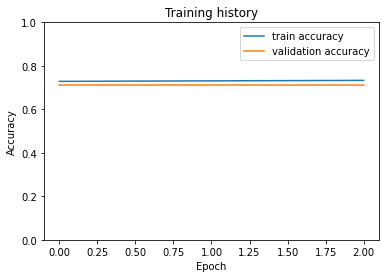

In [274]:
plt.plot(second_history['train_acc'], label='train accuracy')
plt.plot(second_history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1])
plt.show()

## 3. Готовая модель.

In [275]:
from transformers import BertForSequenceClassification, BertConfig

In [276]:
config = BertConfig.from_pretrained(PRE_TRAINED_MODEL_NAME)
config.num_labels = len(class_names)

model_ready = BertForSequenceClassification(config)
model_ready = model_ready.to(device)

loading configuration file https://huggingface.co/prajjwal1/bert-mini/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/a32529b12a03c02e99c269bf68c0c7b8349093f626e860ab9b012e3d9539c539.e6c2a1d71adb3143ecd42222c4604e92ff255a7663c04bb5c4fad770c78e096c
Model config BertConfig {
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 256,
  "initializer_range": 0.02,
  "intermediate_size": 1024,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 4,
  "num_hidden_layers": 4,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.17.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



In [277]:
third_history = train_and_eval(
    EPOCHS,
    model_ready,
    train_data_loader, 
    val_data_loader,
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train),
    len(df_val)
    )

Epoch 1/3
----------
Train loss 1.1004613201989546 accuracy 0.32644134759902954
Val loss 1.1014225530624389 accuracy 0.29860228300094604

Epoch 2/3
----------
Train loss 1.1006233144559925 accuracy 0.3243243396282196
Val loss 1.1014225530624389 accuracy 0.29860228300094604

Epoch 3/3
----------
Train loss 1.1008738584766 accuracy 0.32524171471595764
Val loss 1.1014225530624389 accuracy 0.29860228300094604



In [279]:
third_history['train_acc'] = [score.to('cpu') for score in  third_history['train_acc']]
third_history['val_acc'] = [score.to('cpu') for score in  third_history['val_acc']]

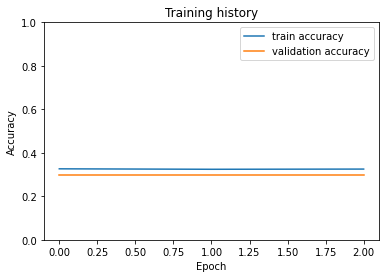

In [280]:
plt.plot(third_history['train_acc'], label='train accuracy')
plt.plot(third_history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1])
plt.show()

Видимо, сочетание конкретно этого мини-берта и этого классификатора не очень хорошее.

## Тесты

In [298]:
def test_accuracy(model, data_loader, n_examples):
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      if not isinstance(outputs, torch.Tensor):
        outputs = outputs.logits
        
      preds = torch.argmax(outputs, dim=1)

      correct_predictions += torch.sum(preds == targets)

  return correct_predictions / n_examples

In [295]:
test_accuracy(model, test_data_loader, len(df_test))

tensor(0.6929, device='cuda:0')

In [296]:
test_accuracy(model_cls, test_data_loader, len(df_test))

tensor(0.6929, device='cuda:0')

In [299]:
test_accuracy(model_ready, test_data_loader, len(df_test))

tensor(0.2982, device='cuda:0')

## Конкретные отзывы

In [285]:
positive_review = """I actually really like this game. I grew up playing the og hungry sharks, so it's nostalgic for me :)
i dont really see what the other reviews mean when they say it takes forever to get new dragons though.
I work full time and attend uni, its been 3 days and I've almost got Zhe Long!! The dragon designs are very unique, and the game is addictive. Give it a try!"""

In [286]:
negative_review = """Lost all of my progress
Own all the dragons before and then i realize they remove facebook login and boom everythings gone.
Contacted the customer service and after waiting for a long time i get back some of my dragons and it's not even half it.
I'm disappointed."""

In [287]:
neutral_review = "This is great game but I'm stuck on a screen the welcome back treasure but it dosent allow me to collect the prize or progress into the game"

In [288]:
encoded_positive = tokenizer.encode_plus(
  positive_review,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  padding='max_length',
  return_attention_mask=True,
  return_tensors='pt',
  truncation=True
)

In [289]:
input_ids = encoded_positive['input_ids'].to(device)
attention_mask = encoded_positive['attention_mask'].to(device)

output = model_cls(input_ids, attention_mask)
prediction = torch.argmax(output, dim=1)

print(f'Review text: {positive_review}')
print(f'Sentiment  : {class_names[prediction]}')

Review text: I actually really like this game. I grew up playing the og hungry sharks, so it's nostalgic for me :)
i dont really see what the other reviews mean when they say it takes forever to get new dragons though.
I work full time and attend uni, its been 3 days and I've almost got Zhe Long!! The dragon designs are very unique, and the game is addictive. Give it a try!
Sentiment  : positive


In [290]:
encoded_negative = tokenizer.encode_plus(
  positive_review,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  padding='max_length',
  return_attention_mask=True,
  return_tensors='pt',
  truncation=True
)

input_ids = encoded_negative['input_ids'].to(device)
attention_mask = encoded_negative['attention_mask'].to(device)

output = model_cls(input_ids, attention_mask)
prediction = torch.argmax(output, dim=1)

print(f'Review text: {negative_review}')
print(f'Sentiment  : {class_names[prediction]}')

Review text: Lost all of my progress
Own all the dragons before and then i realize they remove facebook login and boom everythings gone.
Contacted the customer service and after waiting for a long time i get back some of my dragons and it's not even half it.
I'm disappointed.
Sentiment  : positive


In [291]:
encoded_neutral = tokenizer.encode_plus(
  positive_review,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  padding='max_length',
  return_attention_mask=True,
  return_tensors='pt',
  truncation=True
)

input_ids = encoded_neutral['input_ids'].to(device)
attention_mask = encoded_neutral['attention_mask'].to(device)

output = model_cls(input_ids, attention_mask)
prediction = torch.argmax(output, dim=1)

print(f'Review text: {neutral_review}')
print(f'Sentiment  : {class_names[prediction]}')

Review text: This is great game but I'm stuck on a screen the welcome back treasure but it dosent allow me to collect the prize or progress into the game
Sentiment  : positive
